In [1]:
# ============================================
# 1. Импорт библиотек
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
# ============================================
# 2. Загрузка данных
# ============================================
# Если файл уже загружен в Colab (Слева в "Files") – просто укажи его имя
# Например, если он называется bmw.csv:
df = pd.read_csv('bmw.csv')

# Проверим первые строки и общую информацию
display(df.head())
print(df.shape)
print(df.info())


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


(10781, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB
None


In [4]:
# ============================================
# 3. Проверка пропусков и базовая очистка
# ============================================
# Кол-во пропусков в каждом столбце
print("Пропуски в данных:")
print(df.isna().sum())

# Удалим дубликаты строк, если есть
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Удалено дубликатов: {before - after}")

# Немного здравого смысла по выбросам (можно по желанию менять / убирать):
# оставим только разумные значения цены, пробега и года
df = df[(df['price'] > 500) & (df['price'] < 100000)]
df = df[(df['mileage'] >= 0) & (df['mileage'] < 300000)]
df = df[(df['year'] >= 1990)]  # старые машины отсечём

print("Размер после фильтрации выбросов:", df.shape)


Пропуски в данных:
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64
Удалено дубликатов: 117
Размер после фильтрации выбросов: (10663, 9)


In [5]:
# ============================================
# 4. Разделение на числовые и категориальные признаки
# ============================================
# Наш таргет – price
target_col = 'price'

# Список числовых и категориальных признаков
numeric_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
categorical_features = ['model', 'transmission', 'fuelType']

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)


Числовые признаки: ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Категориальные признаки: ['model', 'transmission', 'fuelType']


In [6]:
# ============================================
# 5. Проверка мультиколлинеарности (по корреляции)
# ============================================
corr_matrix = df[numeric_features + [target_col]].corr()

print("Корреляционная матрица:")
print(corr_matrix)

# Найдём пары признаков с высокой корреляцией > 0.8
upper = corr_matrix.abs().where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = []
for i in upper.index:
    for j in upper.columns:
        if (upper.loc[i, j] > 0.8) and not np.isnan(upper.loc[i, j]):
            high_corr_pairs.append((i, j, upper.loc[i, j]))

print("\nПары признаков с высокой корреляцией (> 0.8):")
for pair in high_corr_pairs:
    print(pair)

# При желании можно вручную удалить один из сильно коррелирующих признаков.
# Например, если бы 'mpg' и 'engineSize' были сильно связаны,
# можно было бы убрать один из них.


Корреляционная матрица:
                year   mileage       tax       mpg  engineSize     price
year        1.000000 -0.772767  0.025249 -0.070155   -0.022424  0.626789
mileage    -0.772767  1.000000 -0.171211  0.117004   -0.006953 -0.607947
tax         0.025249 -0.171211  1.000000 -0.351827    0.431377  0.266688
mpg        -0.070155  0.117004 -0.351827  1.000000   -0.402051 -0.205062
engineSize -0.022424 -0.006953  0.431377 -0.402051    1.000000  0.463699
price       0.626789 -0.607947  0.266688 -0.205062    0.463699  1.000000

Пары признаков с высокой корреляцией (> 0.8):


In [7]:
# ============================================
# 6. Подготовка данных для моделей
# ============================================
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Размер X_train:", X_train.shape)
print("Размер X_test:", X_test.shape)


Размер X_train: (8530, 8)
Размер X_test: (2133, 8)


In [8]:
# ============================================
# 7. Препроцессинг (импьютация + масштабирование + one-hot)
# ============================================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),      # заполняем пропуски медианой
    ('scaler', StandardScaler())                        # масштабируем числовые признаки
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # заполняем пропуски модой
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # one-hot кодирование
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [9]:
# ============================================
# 8. Определение моделей
# ============================================
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}


In [11]:
# ============================================
# 9. Обучение моделей и сравнение MAE, RMSE, R^2
# ============================================
results = []

for name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5   # исправлено!
    r2 = r2_score(y_test, y_pred)

    results.append({
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values(by="RMSE"))


,model,MAE,RMSE,R2
1,RandomForest,1551.333646,2363.928326,0.957292
2,XGBoost,1680.563721,2417.115740,0.955349
0,LinearRegression,2810.169759,4041.810257,0.875150


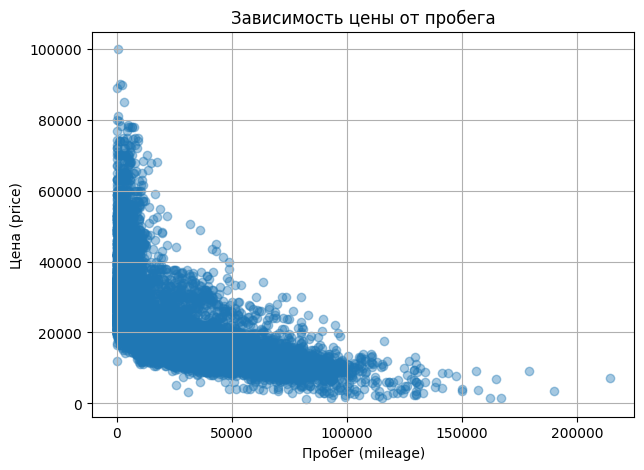

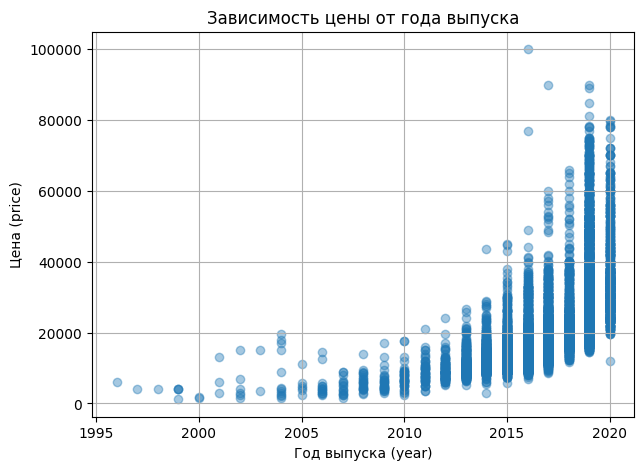

In [12]:
# ============================================
# 10. Визуализация: цена vs пробег и цена vs год выпуска
# ============================================

plt.figure(figsize=(7, 5))
plt.scatter(df['mileage'], df['price'], alpha=0.4)
plt.xlabel("Пробег (mileage)")
plt.ylabel("Цена (price)")
plt.title("Зависимость цены от пробега")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(df['year'], df['price'], alpha=0.4)
plt.xlabel("Год выпуска (year)")
plt.ylabel("Цена (price)")
plt.title("Зависимость цены от года выпуска")
plt.grid(True)
plt.show()
